- [1. Import Packages](#1)
- [2. Assembling Dataset](#2)
- [3. Model Training](#3)

## 1. Import Packages <a id='1'></a>

In [50]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler



## 2. Assembling Dataset <a id='2'></a>

In [6]:
all_features_path = '/Users/liqingyang/Documents/GitHub/variance_prediction/data/cleaned_data/btc_1d_engineered_selected_features.csv'
all_features = pd.read_csv(all_features_path)
all_features.columns

Index(['date', 'close', 'Volume BTC', 'Volume USD', '5_day_vol',
       'rsi_14_over_30', 'rsi_7_over_14', 'vol_ratio_30_over_150', '7_day_vol',
       'target'],
      dtype='object')

In [51]:
timesteps = 10
np.random.seed(0)
scaler = StandardScaler()
features = all_features[['close', 'Volume BTC', 'Volume USD', '5_day_vol',
       'rsi_14_over_30', 'rsi_7_over_14', 'vol_ratio_30_over_150', '7_day_vol']]
target = all_features['target'].to_numpy().reshape(-1, 1)
target_scaled = scaler.fit_transform(target)


def create_sequences(target, timesteps):
    X, y = [], []
    for i in range(len(target) - timesteps):
        X.append(target[i:(i + timesteps)])
        y.append(target[i + timesteps])
    return np.array(X), np.array(y)


X, y = create_sequences(target_scaled, timesteps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=0)


## 3. Model Training <a id='3'></a>

In [52]:
lstm = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], 1)),  
    Dense(1)
])

lstm.compile(optimizer='adam', loss='mse')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [53]:
history = lstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))
test_loss = lstm.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
predictions = lstm.predict(X_test)
predictions_inverse = scaler.inverse_transform(predictions)
y_test_inverse = scaler.inverse_transform(y_test)
# y_pred_inverse = scaler.inverse_transform(y_pred)

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.8800 - val_loss: 0.2676
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3827 - val_loss: 0.1941
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2855 - val_loss: 0.1442
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2147 - val_loss: 0.1138
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1793 - val_loss: 0.1084
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1663 - val_loss: 0.1106
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1639 - val_loss: 0.0969
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1505 - val_loss: 0.0934
Epoch 9/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1534 - val_loss: 0.1049
Epoch 10/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1388 - val_loss: 0.1028
Epoch 11/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1408 - val_loss: 0.0919
Epoch 12/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1357 - val_l

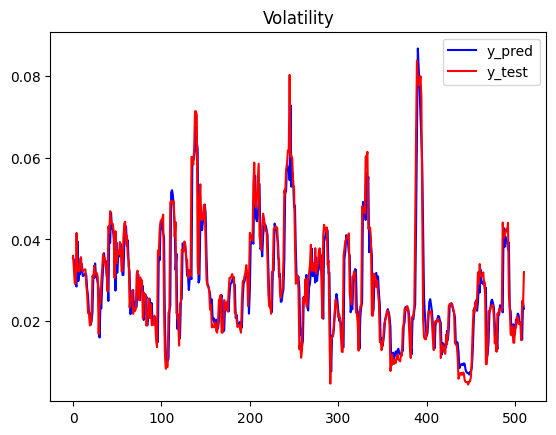

In [54]:
y_pred_inverse = pd.Series([i[0] for i in predictions_inverse])
y_test_inverse_ = pd.Series([i[0] for i in y_test_inverse])
_ = y_pred_inverse.plot(color='blue', label='y_pred')
_ = y_test_inverse_.plot(color='red', label='y_test')
_ = plt.title("Volatility")
_ = plt.legend()
_ = plt.show()

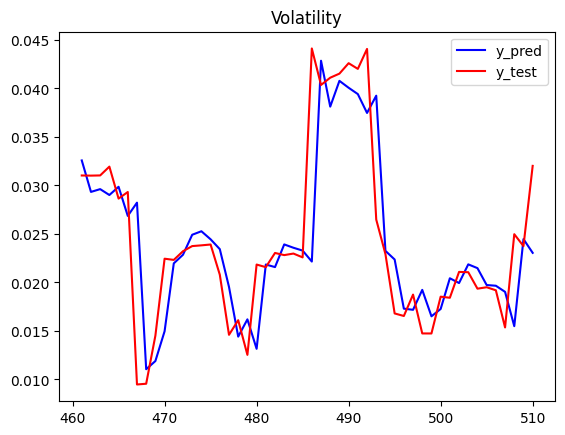

In [55]:
_ = y_pred_inverse.iloc[-50:].plot(color='blue', label='y_pred')
_ = y_test_inverse_.iloc[-50:].plot(color='red', label='y_test')
_ = plt.title("Volatility")
_ = plt.legend()
_ = plt.show()